# Space2Stats Client - UI Widgets Demo

In [1]:
import pandas as pd
import requests
import ipywidgets as widgets
from IPython.display import display
from typing import List
from space2stats_client import Space2StatsClient, CrossSectionFieldSelector, TimeSeriesFieldSelector
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import from_geojson
from shapely.geometry import shape
import json
from plotnine import (
    ggplot,
    aes,
    geom_map,
    coord_fixed,
    facet_wrap,
    scale_fill_distiller,
    element_rect,
    theme_void,
    theme,
)


# Init Client
client = Space2StatsClient()


# Fetch an AOI

<Axes: >

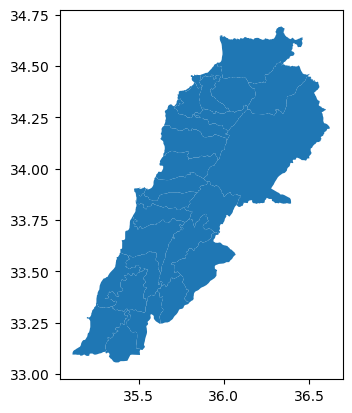

In [2]:
# Fetch an AOI
ISO3 = "LBN" # Lebanon
ADM = "ADM2" # Level 2 administrative boundaries
adm_boundaries = client.fetch_admin_boundaries(ISO3, ADM)
adm_boundaries.plot()

# Use Cross-Section Field Selector to Select Relevent Fields

In [3]:
# Display the Cross-Section Field Selector widget
# In this example we are selecting all of the NTL data
csfs = CrossSectionFieldSelector(client)
csfs.display()

# Fetch Cross-Section Data from the API

In [4]:
# Get the selected fields
selected_fields = csfs.get_selected_fields()

# Get available topics/datasets
gdf = client.get_summary(
    gdf=adm_boundaries,
    spatial_join_method="centroid",
    fields=selected_fields,
    geometry="polygon"
)

# Convert to gdf
df["geometry"] = df["geometry"].apply(lambda geom: from_geojson(geom))
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,index_gdf,index_h3,hex_id,geometry,sum_viirs_ntl_2012,...,sum_viirs_ntl_2015,sum_viirs_ntl_2016,sum_viirs_ntl_2017,sum_viirs_ntl_2018,sum_viirs_ntl_2019,sum_viirs_ntl_2020,sum_viirs_ntl_2021,sum_viirs_ntl_2022,sum_viirs_ntl_2023,sum_viirs_ntl_2024
0,Bent Jbail,,6925839B74640193916916,LBN,ADM2,0,0,862db1887ffffff,"{""type"":""Polygon"",""coordinates"":[[[35.42202628...",553.849976,...,472.389984,468.510010,590.809998,583.760010,640.440002,631.760010,561.890015,357.530029,445.319977,287.669983
1,Bent Jbail,,6925839B74640193916916,LBN,ADM2,0,1,862db1c2fffffff,"{""type"":""Polygon"",""coordinates"":[[[35.37138233...",435.399994,...,501.020020,516.200012,683.869995,605.319946,634.660034,600.270020,585.359985,499.360016,637.059998,465.840027
2,Bent Jbail,,6925839B74640193916916,LBN,ADM2,0,2,862db1c67ffffff,"{""type"":""Polygon"",""coordinates"":[[[35.42928900...",609.630005,...,739.010010,806.690002,947.750000,925.270020,963.229980,822.190002,684.469971,317.239990,621.179993,409.529999
3,Bent Jbail,,6925839B74640193916916,LBN,ADM2,0,3,862db1c77ffffff,"{""type"":""Polygon"",""coordinates"":[[[35.43291343...",834.940002,...,1293.869995,1256.030029,1366.219971,1431.680054,1241.159912,1068.500000,1026.969971,541.910034,1068.199951,575.159973
4,Bent Jbail,,6925839B74640193916916,LBN,ADM2,0,4,862db1d47ffffff,"{""type"":""Polygon"",""coordinates"":[[[35.30246301...",562.679993,...,641.229980,630.179993,789.910034,674.929993,565.699951,564.429993,517.429993,359.380005,510.619995,324.180023


# Visualize the Cross-Section Data

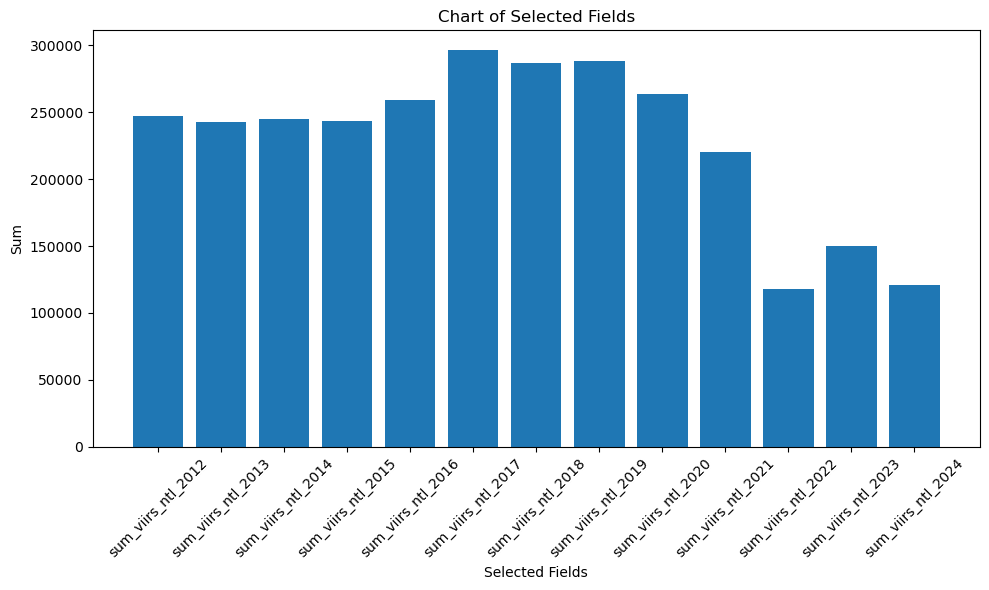

In [5]:
# Sum the values for each selected field (if numeric)
summary_data = gdf[selected_fields].sum()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(summary_data.index, summary_data.values)
plt.xlabel('Selected Fields')
plt.ylabel('Sum' if 'summary_data' in locals() else 'Count')
plt.title('Chart of Selected Fields')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
# Now create your risk map
nlt_2012 = gdf.explore(
    column="sum_viirs_ntl_2012",
    tooltip=[],
    cmap="OrRd",
    legend=True,
    scheme="quantiles",
    legend_kwds=dict(colorbar=True, caption="sum_viirs_ntl_2012", interval=False),
    style_kwds=dict(weight=0.5, fillOpacity=0.8),
    name="sum_viirs_ntl_2012",
)

nlt_2012

AttributeError: 'DataFrame' object has no attribute 'explore'

# Use Time Series Field Selector to Select Relevent Fields

In [ ]:
# Display the Time Sereis Field Selector widget
# In this example we are SPI data
tsfs = TimeSeriesFieldSelector(client)
tsfs.display()

# Fetch Time Series Data from the API

In [ ]:
# Define the fields and parameters
selections = tsfs.get_selections()
selected_fields = selections['fields']
selected_start_date = selections['time_period']['start_date'].isoformat()
selected_end_date = selections['time_period']['end_date'].isoformat()

all_adm2_data = []


# Loop through each ADM2 region to fetch its data
for idx, adm2_feature in adm_boundaries.iterrows():
    try:
        feature_gdf = gpd.GeoDataFrame([adm2_feature], geometry='geometry')

        result_df = client.get_timeseries(
            gdf=feature_gdf,
            spatial_join_method="centroid",
            fields=selected_fields,
            start_date=selected_start_date,
            end_date=selected_end_date,
            geometry= "polygon"
        )

        if not result_df.empty:
            region_name = adm2_feature['shapeName']
            result_df['region'] = region_name
            all_adm2_data.append(result_df)
            print(f"Retrieved data for {region_name}")
        else:
            print(f"No data found for {adm2_feature['shapeName']}")
    except Exception as e:
        print(f"Error retrieving data for region: {str(e)}")

# Combine all the dataframes
if all_adm2_data:
    all_adm2_data = pd.concat(all_adm2_data, ignore_index=True)
    print(f"Total records: {len(all_adm2_data)}")
else:
    print("No data was retrieved")

# Visualize the Time Series Data

In [ ]:
# Convert response data to a pandas dataframe
df = pd.DataFrame(all_adm2_data)

# Convert date strings to datetime objects
if 'date' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df.head(2)

In [ ]:
# Convert geometry to shapely objects
if isinstance(df["geometry"].iloc[0], str):
    df["geometry"] = df["geometry"].apply(json.loads)
df["geometry"] = df["geometry"].apply(shape)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf['ym'] = gdf['date'].dt.strftime('%Y-%m')

In [ ]:
(
    ggplot(gdf)
    + geom_map(aes(fill="spi"), size=0)
    + scale_fill_distiller(type="div", palette="RdBu", name="SPI", limits=(-2, 2))
    + facet_wrap(
        "ym",
        ncol=4,
    )
    + coord_fixed(expand=False)
    + theme_void()
    + theme(
        figure_size=(8, 8),
        plot_background=element_rect(fill="white"),
        panel_spacing=0.025
    )
)